# Table of Contents

1. [Import Libraries](#import-libraries)
2. [Load and Prepare Data](#load-and-prepare-data)
3. [Convert Data to spaCy Format](#convert-data-to-spacy-format)
4. [Initialize spaCy Model](#initialize-spacy-model)
5. [Add labels to the NER model](#add-labels-to-the-ner-model)
6. [Train the Mode](#train-the-mode)
7. [Save the trained model](#save-the-trained-model)
8. [Plot the training loss over iterations](#plot-the-training-loss-over-iterations)

## Import Libraries

In [2]:
# Import Libraries
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
from tqdm import tqdm
import ast
import pandas as pd
import os
import matplotlib.pyplot as plt  # For visualization
import seaborn as sns

## Load and Prepare Data

Sample Data:


,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"['Design', 'Thinking', 'for', 'innovation', 'r...","[True, True, True, True, False, False, True, F...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"['Diego', 'Estrada', '\n\n', 'Design', 'Thinki...","[True, False, False, True, True, False, False,...","['B-NAME_STUDENT', 'I-NAME_STUDENT', 'O', 'O',..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"['Reporting', 'process', '\n\n', 'by', 'Gilber...","[True, False, False, True, True, False, False,...","['O', 'O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"['Design', 'Thinking', 'for', 'Innovation', '\...","[True, True, True, False, False, True, False, ...","['O', 'O', 'O', 'O', 'O', 'B-NAME_STUDENT', 'I..."
4,56,Assignment: Visualization Reflection Submitt...,"['Assignment', ':', '\xa0 ', 'Visualization', ...","[False, False, False, False, False, False, Fal...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."



Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             6807 non-null   int64 
 1   full_text            6807 non-null   object
 2   tokens               6807 non-null   object
 3   trailing_whitespace  6807 non-null   object
 4   labels               6807 non-null   object
dtypes: int64(1), object(4)
memory usage: 266.0+ KB
None

Dataset Statistics:


,document
count,6807.000000
mean,14739.782283
std,4920.715769
min,7.000000
25%,11061.500000
50%,14818.000000
75%,18974.000000
max,22687.000000


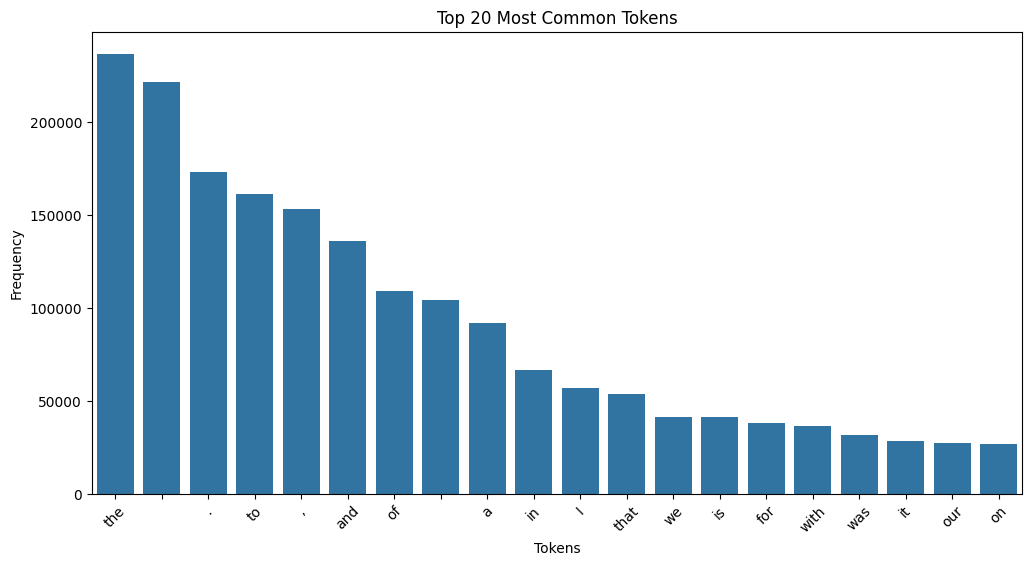

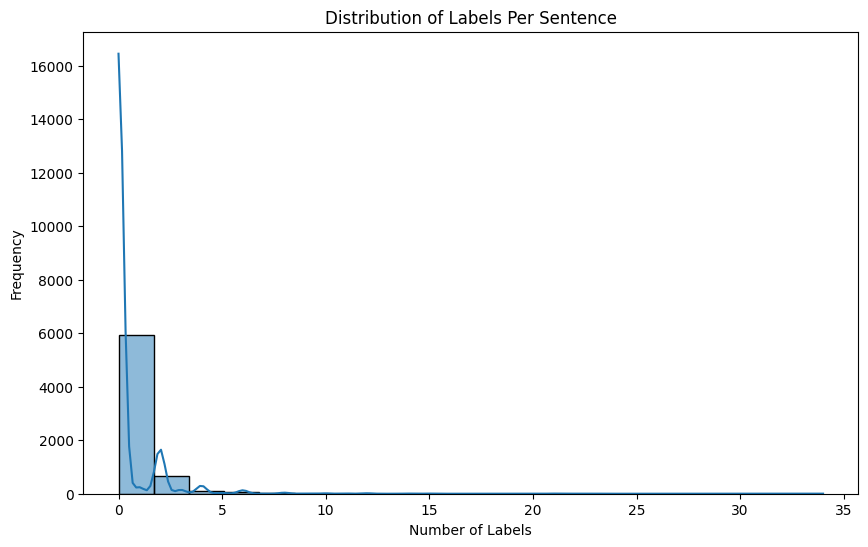

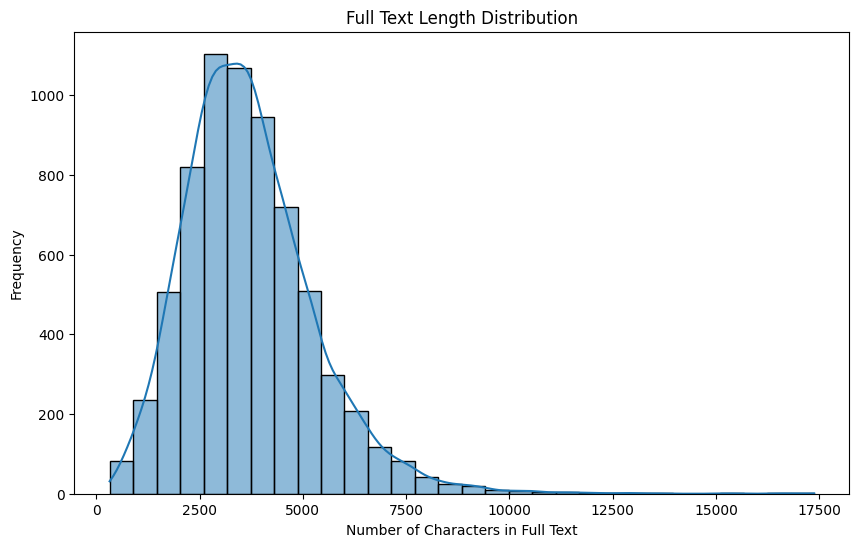

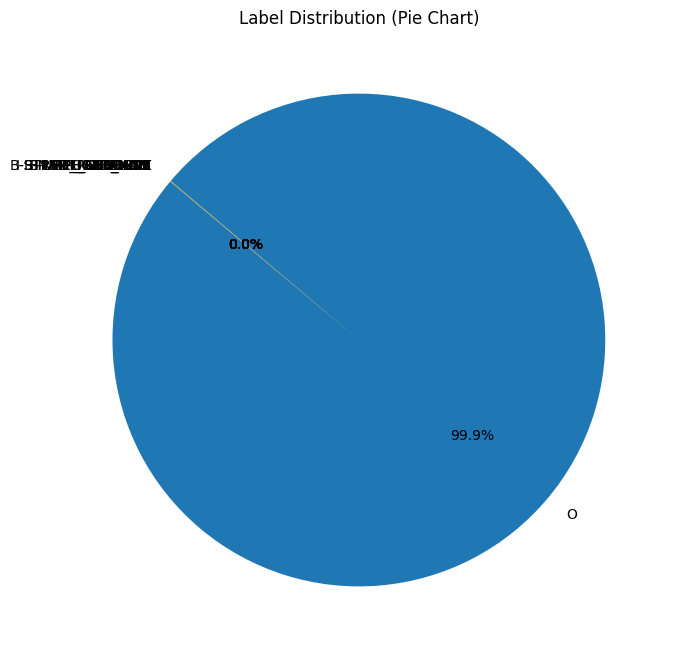

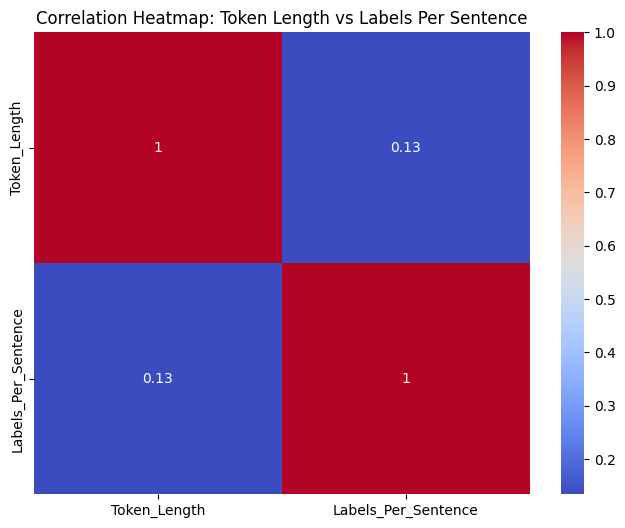

In [6]:
# Load and Prepare Data
data_path = 'dataset/train.csv'
data = pd.read_csv(data_path)

# Display the first few rows
print("Sample Data:")
display(data.head())

# 3. Exploratory Data Analysis (EDA)

# 3.1 Overview of Data
print("\nDataset Overview:")
print(data.info())

print("\nDataset Statistics:")
display(data.describe())



# Additional EDA - 3.4 Token Frequency Distribution
from collections import Counter

def get_token_frequency(data):
    token_counter = Counter()
    for tokens in data['tokens']:
        try:
            tokens_list = ast.literal_eval(tokens)
            token_counter.update(tokens_list)
        except:
            continue
    return token_counter

# Calculate token frequencies
token_counter = get_token_frequency(data)
top_tokens = token_counter.most_common(20)

# Plot top tokens
plt.figure(figsize=(12, 6))
sns.barplot(x=[token[0] for token in top_tokens], y=[token[1] for token in top_tokens])
plt.title("Top 20 Most Common Tokens")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# 3.5 Top Labels Per Sentence
def labels_per_sentence(data):
    labels_count = []
    for labels in data['labels']:
        try:
            labels_list = ast.literal_eval(labels)
            labels_count.append(len([label for label in labels_list if label != 'O']))
        except:
            continue
    return labels_count

# Calculate label count per sentence
labels_count = labels_per_sentence(data)

# Plot label count per sentence
plt.figure(figsize=(10, 6))
sns.histplot(labels_count, bins=20, kde=True)
plt.title("Distribution of Labels Per Sentence")
plt.xlabel("Number of Labels")
plt.ylabel("Frequency")
plt.show()

# 3.6 Full Text Length Distribution
def text_length_distribution(data):
    text_lengths = data['full_text'].apply(len)
    return text_lengths

# Calculate text lengths
text_lengths = text_length_distribution(data)

# Plot full text lengths
plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=30, kde=True)
plt.title("Full Text Length Distribution")
plt.xlabel("Number of Characters in Full Text")
plt.ylabel("Frequency")
plt.show()

# 3.7 Pie Chart of Labels
plt.figure(figsize=(8, 8))
plt.title("Label Distribution (Pie Chart)")
plt.pie(label_counts, labels=label_counts.index, autopct="%1.1f%%", startangle=140)
plt.show()

# 3.8 Heatmap of Token Length vs Label Count
import numpy as np

# Prepare heatmap data
heatmap_data = pd.DataFrame({
    'Token_Length': token_lengths,
    'Labels_Per_Sentence': labels_count
})

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap: Token Length vs Labels Per Sentence")
plt.show()





## Convert Data to spaCy Format

In [8]:
# Function to convert data to spaCy's training format
def convert_to_spacy_format(data):
    db = DocBin()
    for _, row in tqdm(data.iterrows(), total=len(data)):
        doc = nlp.make_doc(row['full_text'])
        ents = []
        try:
            tokens = ast.literal_eval(row['tokens'])
            labels = ast.literal_eval(row['labels'])
            start_idx = 0
            for token, label in zip(tokens, labels):
                if label != 'O':
                    token_start = row['full_text'].find(token, start_idx)
                    if token_start != -1:
                        token_end = token_start + len(token)
                        ents.append((token_start, token_end, label))
                    start_idx = token_start + len(token)
            doc.ents = ents
            db.add(doc)
        except Exception as e:
            continue
    return db

# Initialize spaCy model
nlp = spacy.blank("en")

# Convert data to spaCy format
train_data = convert_to_spacy_format(data)

# Save the converted training data
train_data.to_disk("./training_data.spacy")

100%|██████████| 6807/6807 [00:47<00:00, 143.31it/s]


## Initialize spaCy Model

In [9]:
# Create a new blank model with the NER pipeline
nlp_ner = spacy.blank("en")
ner = nlp_ner.add_pipe("ner")

## Add labels to the NER model

In [10]:
# Add labels to the NER model
for _, row in data.iterrows():
    try:
        labels = ast.literal_eval(row['labels'])
        for label in labels:
            if label != 'O' and not ner.has_label(label):
                ner.add_label(label)
    except:
        continue

## Train the Mode

In [ ]:
# Training settings
n_iter = 30
batch_size = 1000

# Train the model
optimizer = nlp_ner.begin_training()
loss_history = []  # To track losses

for i in range(n_iter):
    losses = {}
    docs = list(train_data.get_docs(nlp_ner.vocab))
    for batch in tqdm(spacy.util.minibatch(docs, size=batch_size), desc=f"Iteration {i}"):
        examples = []
        for doc in batch:
            examples.append(Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}))
        nlp_ner.update(examples, drop=0.5, losses=losses)
    print(f"Losses at iteration {i}: {losses}")
    loss_history.append(losses['ner'])

## Save the trained model

In [ ]:
# Save the trained model
output_dir = "./ner_model"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
nlp_ner.to_disk(output_dir)

## Plot the training loss over iterations

In [ ]:
# Plot the training loss over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(n_iter), loss_history, marker='o')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [2]:
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
from tqdm import tqdm
import ast
import pandas as pd
import os

# Load and prepare the data
data_path = 'dataset/train.csv'
data = pd.read_csv(data_path)

# Function to convert data to spaCy's training format
def convert_to_spacy_format(data):
    db = DocBin()
    for _, row in tqdm(data.iterrows(), total=len(data)):
        doc = nlp.make_doc(row['full_text'])
        ents = []
        try:
            tokens = ast.literal_eval(row['tokens'])
            labels = ast.literal_eval(row['labels'])
            
            start_idx = 0
            for token, label in zip(tokens, labels):
                if label != 'O':
                    token_start = row['full_text'].find(token, start_idx)
                    if token_start != -1:
                        token_end = token_start + len(token)
                        ents.append((token_start, token_end, label))
                    start_idx = token_start + len(token)
            
            doc.ents = ents
            db.add(doc)
        except Exception as e:
            continue
    
    return db

# Initialize spaCy model
nlp = spacy.blank("en")

# Convert data to spaCy format
train_data = convert_to_spacy_format(data)

# Save the converted training data
train_data.to_disk("./training_data.spacy")

# Create a new blank model with the NER pipeline
nlp_ner = spacy.blank("en")
ner = nlp_ner.add_pipe("ner")

# Add labels to the NER model
for _, row in data.iterrows():
    try:
        labels = ast.literal_eval(row['labels'])
        for label in labels:
            if label != 'O' and not ner.has_label(label):
                ner.add_label(label)
    except:
        continue

# Training settings
n_iter = 30
batch_size = 1000

# Train the model
optimizer = nlp_ner.begin_training()
for i in range(n_iter):
    losses = {}
    docs = list(train_data.get_docs(nlp_ner.vocab))
    for batch in tqdm(spacy.util.minibatch(docs, size=batch_size), desc=f"Iteration {i}"):
        examples = []
        for doc in batch:
            examples.append(Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}))
        nlp_ner.update(examples, drop=0.5, losses=losses)
    print(f"Losses at iteration {i}: {losses}")

# Save the trained model
output_dir = "./ner_model"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


100%|██████████| 6807/6807 [00:48<00:00, 141.43it/s]
Iteration 0: 6it [07:06, 71.04s/it]


Losses at iteration 0: {'ner': np.float32(1382361.1)}


Iteration 1: 6it [07:03, 70.55s/it]


Losses at iteration 1: {'ner': np.float32(154662.56)}


Iteration 2: 6it [06:44, 67.42s/it]


Losses at iteration 2: {'ner': np.float32(117.48149)}


Iteration 3: 6it [06:45, 67.57s/it]


Losses at iteration 3: {'ner': np.float32(8.280855e-07)}


Iteration 4: 6it [06:44, 67.35s/it]


Losses at iteration 4: {'ner': np.float32(8.26958e-22)}


Iteration 5: 6it [06:55, 69.22s/it]


Losses at iteration 5: {'ner': np.float32(1.6037158e-29)}


Iteration 6: 6it [09:50, 98.38s/it] 


Losses at iteration 6: {'ner': np.float32(4.5198467e-37)}


Iteration 7: 6it [16:35, 165.85s/it]


Losses at iteration 7: {'ner': np.float32(5.999336e-39)}


Iteration 8: 6it [25:14, 252.37s/it]


Losses at iteration 8: {'ner': np.float32(2.87e-43)}


Iteration 9: 6it [31:31, 315.20s/it]


Losses at iteration 9: {'ner': np.float32(1.23e-43)}


Iteration 10: 6it [38:50, 388.49s/it]


Losses at iteration 10: {'ner': np.float32(3.9e-44)}


Iteration 11: 6it [37:43, 377.19s/it]


Losses at iteration 11: {'ner': np.float32(4.6e-44)}


Iteration 12: 6it [39:43, 397.30s/it]


Losses at iteration 12: {'ner': np.float32(1e-45)}


Iteration 13: 6it [41:22, 413.69s/it]


Losses at iteration 13: {'ner': np.float32(7e-45)}


Iteration 14: 6it [42:20, 423.37s/it]


Losses at iteration 14: {'ner': np.float32(3.8e-44)}


Iteration 15: 6it [40:16, 402.72s/it]


Losses at iteration 15: {'ner': np.float32(1.4e-44)}


Iteration 16: 6it [43:28, 434.68s/it]


Losses at iteration 16: {'ner': np.float32(4e-45)}


Iteration 17: 6it [41:11, 411.91s/it]


Losses at iteration 17: {'ner': np.float32(5.66e-43)}


Iteration 18: 6it [1:02:38, 626.40s/it]


Losses at iteration 18: {'ner': np.float32(5.89e-43)}


Iteration 19: 6it [1:04:10, 641.81s/it]


Losses at iteration 19: {'ner': np.float32(1.96e-43)}


Iteration 20: 6it [41:12, 412.15s/it]


Losses at iteration 20: {'ner': np.float32(3.62e-43)}


Iteration 21: 6it [38:13, 382.28s/it]


Losses at iteration 21: {'ner': np.float32(7.8e-44)}


Iteration 22: 6it [38:13, 382.23s/it]


Losses at iteration 22: {'ner': np.float32(2.26e-43)}


Iteration 23: 6it [38:52, 388.80s/it]


Losses at iteration 23: {'ner': np.float32(4e-45)}


Iteration 24: 6it [38:20, 383.47s/it]


Losses at iteration 24: {'ner': np.float32(1e-44)}


Iteration 25: 6it [39:42, 397.07s/it]


Losses at iteration 25: {'ner': np.float32(4e-45)}


Iteration 26: 6it [38:29, 384.97s/it]


Losses at iteration 26: {'ner': np.float32(3e-45)}


Iteration 27: 6it [39:10, 391.71s/it]


Losses at iteration 27: {'ner': np.float32(6e-45)}


Iteration 28: 6it [41:12, 412.11s/it]


Losses at iteration 28: {'ner': np.float32(1e-45)}


Iteration 29: 6it [40:54, 409.11s/it]

Losses at iteration 29: {'ner': np.float32(1.37e-43)}
